Per funzionare, il presente notebook ha bisogno della cartella contenente i dati. <br> <br>
Dataset originale: <br>
https://github.com/vkaya24100/Different-Weapon-Types-datasets <br>
E' possibile importarli semplicemente aggiungendo una scorciatoia al proprio Drive per la seguente cartella: <br>
**https://drive.google.com/drive/folders/1m3muJ_peOKJkbCx-08ixRADQnrfaId0i?usp=sharing**

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
from google.colab import drive
from shutil import copyfile, rmtree, copytree
import random
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import seaborn as sns
from keras.preprocessing import image as kimage
from matplotlib import patches
from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.signal import fftconvolve

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['grid.alpha']=0

In [ ]:
drive.mount('/content/gdrive')
copytree('gdrive/MyDrive/Data_DigitalSignalsProject/image/Pistol','Pistol')
copytree('gdrive/MyDrive/Data_DigitalSignalsProject/retrieval','retrieval')
copytree('gdrive/MyDrive/Data_DigitalSignalsProject/retrieval_label','retrieval_label')

## FUNZIONI 

In [ ]:
base_net = keras.applications.MobileNetV2(input_shape=(150,150,3),
                                          weights='imagenet',  
                                          include_top=False,    
                                          pooling='max')


In [ ]:
def cr(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
def cos_distance(a,b):
  if norm(a)!=0 and norm(b)!=0:
    res = dot(a, b)/(norm(a)*norm(b))
  else:
    res = 0
  return 1-res

In [ ]:
def get_square(a,b, feat_pistol):
  sim = []
  for frame in a:
    sim.append(neural_features(frame))

  sim_bb = []

  for i in sim:
    sim_bb.append(cos_distance(i, feat_pistol))

  return b[np.argmin(sim_bb)], sim_bb[np.argmin(sim_bb)]

In [ ]:
def get_best_square(a,b, template1, template2, template3):
  nf1 = [neural_features(i) for i in template1]
  nf2 = [neural_features(i) for i in template2]
  nf3 = [neural_features(i) for i in template3]

  coordinate = []
  distanza = []
  for i in nf1:
    best, conf = get_square(a,b, i)
    coordinate.append(best)
    distanza.append(conf)
  ct1 = coordinate[np.argmin(distanza)]
  dt1 = distanza[np.argmin(distanza)]

  coordinate = []
  distanza = []
  for i in nf2:
    best, conf = get_square(a,b, i)
    coordinate.append(best)
    distanza.append(conf)
  ct2 = coordinate[np.argmin(distanza)]
  dt2 = distanza[np.argmin(distanza)]

  coordinate = []
  distanza = []
  for i in nf3:
    best, conf = get_square(a,b, i)
    coordinate.append(best)
    distanza.append(conf)
  ct3 = coordinate[np.argmin(distanza)]
  dt3 = distanza[np.argmin(distanza)]

  return [ct1,ct2,ct3, dt1,dt2,dt3]

In [ ]:
def get_label(path):
  with open(f'retrieval_label/{path}.txt') as f:
    lines = f.readlines()
    ff = lines[1][:-1].split(' ')
    return [int(ff[0]), int(ff[2]), int(ff[1]), int(ff[3]) ]

In [ ]:
def get_metric(a,b):
  h = min(a[3],b[3])-max(a[2],b[2]) 
  w = min(a[1], b[1]) -max(a[0],b[0])

  if h>0 and w>0:
    intersection = h*w
  else:
    intersection = 0

  area1 = (a[1]-a[0])*(a[3]-a[2])
  area2 = (b[1]-b[0])*(b[3]-b[2])

  union = area1 + area2 - intersection

  return intersection/union

In [ ]:
def neural_features(image):
  image = image.astype('float32') 
  array = keras.preprocessing.image.img_to_array(cv2.resize(image, (150,150)))
  array_prep = keras.applications.mobilenet_v2.preprocess_input(array)
  array_4d = np.expand_dims(array_prep, axis=0)
  features = base_net.predict(array_4d, verbose=False)
  return features.flatten()

In [ ]:
def split_image(img):
  h=img.shape[0]
  w=img.shape[1]
  o=[]
  coord = []

  for dim in [60, 100, 150]:
    step = 20
    n_step_x = int((w-dim+1)/step)
    n_step_y = int((h-dim+1)/step)

    for x_batch in range(n_step_x):
      x_s = x_batch*step
      x_f = x_batch*step + dim

      for y_batch in range(n_step_y):
        y_s = y_batch*step
        y_f = y_batch*step + dim

        o.append(img[y_s:y_f,x_s:x_f])
        coord.append([x_s, x_f, y_s, y_f])

  return o, coord

In [ ]:
# L'immagine viene portata alla dimensione 224x224 senza modificare le proporzioni

def resize_image(image, dim=224):
  (h, w) = image.shape

  if h == w:
    resized = cv2.resize(image, [dim,dim])

  elif h<w:
    diff = w-h
    squared = np.concatenate((image, np.zeros((diff, w))+255) ,axis=0)
    resized = cv2.resize(squared, [dim,dim])

  elif h>w:
    diff = h-w
    squared = np.concatenate((image, np.zeros((h, diff))+255) ,axis=1)
    resized = cv2.resize(squared, [dim,dim])

  return resized

In [ ]:
# L'immagine viene centrata, sfruttando l'informazione che tutti gli sfondi sono perfettamente bianchi

def center_image(img, resize=True):
  if resize==True:
    img = resize_image(img)

  up = 0
  down = 0
  left = 0
  right = 0


  for row in range(224):
    if all((img[row,:])==255):
      up = up+1
    else:
      break

  for row in range(224):
    if all((img[-row-1,:])==255):
      down = down+1
    else:
      break

  for col in range(224):
    if all((img[:,col])==255):
      left = left+1
    else:
      break

  for col in range(224):
    if all((img[:,-col-1])==255):
      right = right+1
    else:
      break
  if up!=down:
    if up>down:
      diff = up-down
      img = np.concatenate((img[int(diff/2):,:], np.zeros((int(diff/2), 224))+255),axis=0)

    elif up<down:
      diff = down-up+1
      img = np.concatenate((np.zeros((int(diff/2), 224))+255, img[:-int(diff/2),:]),axis=0)
  if left!=right:
    if left>right:
      diff = left-right
      img = np.concatenate((img[:,int(diff/2):], np.zeros((224, int(diff/2)))+255),axis=1)

    elif left<right:
      diff = right-left+1
      img = np.concatenate((np.zeros((224, int(diff/2)))+255,  img[:,:-int(diff/2)] ),axis=1)

  return img


In [ ]:
# Il centramento dell'immagine viene effettuato su tutti e tre i canali colore

def center_image_rgb(img):
  c0 = center_image(img[:,:,0])
  c1 = center_image(img[:,:,1])
  c2 = center_image(img[:,:,2])
  final = np.stack((c0,c1,c2), axis=2).astype(int)
  return final

In [ ]:
# Rotazione dell'immagine

def rotate_image(img, angle):
  img = img.astype(np.uint8)
  (h, w) = img.shape[:2]
  (cX, cY) = (w // 2, h // 2)

  M = cv2.getRotationMatrix2D((cX, cY), angle, 1)
  c0 = cv2.warpAffine(img[:,:,0], M, (w, h), borderValue=255.) 
  c1 = cv2.warpAffine(img[:,:,1], M, (w, h), borderValue=255.) 
  c2 = cv2.warpAffine(img[:,:,2], M, (w, h), borderValue=255.)

  rotated = np.stack((c0,c1,c2), axis=2).astype(int)
  return rotated

In [ ]:
# Modifica della luminanza

def change_luminance(img, luminance_lim = 10):
  luminance_array = np.repeat(np.random.randint(-abs(luminance_lim), abs(luminance_lim)), 224 * 224 * 3).reshape(224, 224, 3)
  img = np.clip(img + luminance_array, 0, 255).astype(int)
  return img

In [ ]:
# Aggiunta di un quadratino bianco (rumore)

def add_square(img):
  x_s = np.random.randint(40, 130)
  y_s = np.random.randint(40, 130)

  dim = np.random.randint(10, 40)

  x_f = x_s + dim
  y_f = y_s + dim

  img[:,:,0][y_s:y_f,x_s:x_f] = 255
  img[:,:,1][y_s:y_f,x_s:x_f] = 255
  img[:,:,2][y_s:y_f,x_s:x_f] = 255

  return img

## NORMALIZED CROSS-CORRELATION APPROACH

In [ ]:
def normxcorr2(template, image, mode="full"):
    if np.ndim(template) > np.ndim(image) or \
            len([i for i in range(np.ndim(template)) if template.shape[i] > image.shape[i]]) > 0:
        print("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.")

    template = template - np.mean(template)
    image = image - np.mean(image)

    a1 = np.ones(template.shape)

    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)
    
    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    out[np.where(np.logical_not(np.isfinite(out)))] = 0

    out = cv2.rotate(out, cv2.ROTATE_180)
    
    return out

### experiment 1

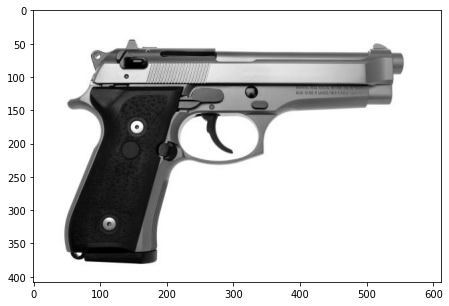

In [ ]:
template = cv2.imread('Pistol/tabanca1115.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (130,70), interpolation = cv2.INTER_AREA)

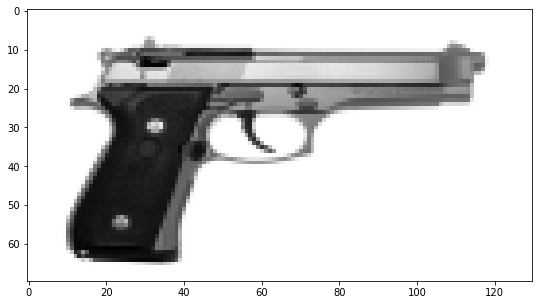

In [ ]:
plt.imshow(cr(template))

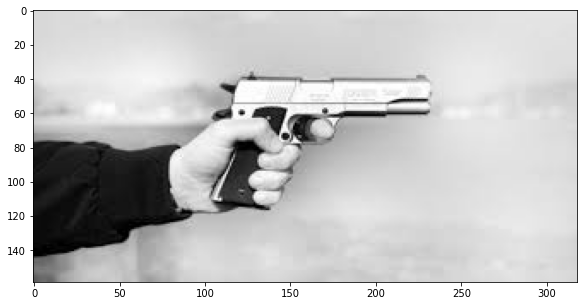

In [ ]:
im = cv2.imread('retrieval/131.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

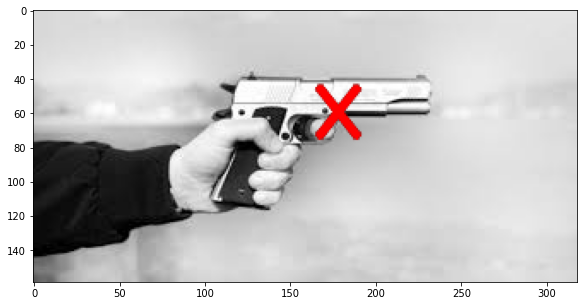

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA) )

### experiment 2

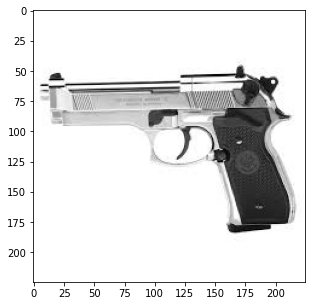

In [ ]:
template = cv2.imread('Pistol/tabanca1041.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (130,70), interpolation = cv2.INTER_AREA)

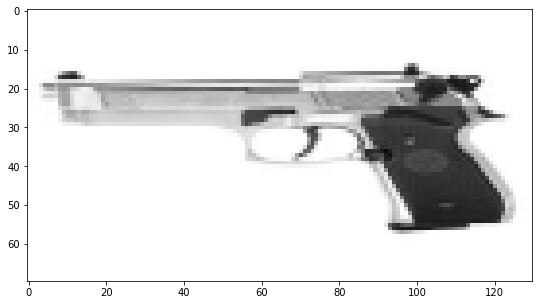

In [ ]:
plt.imshow(cr(template))

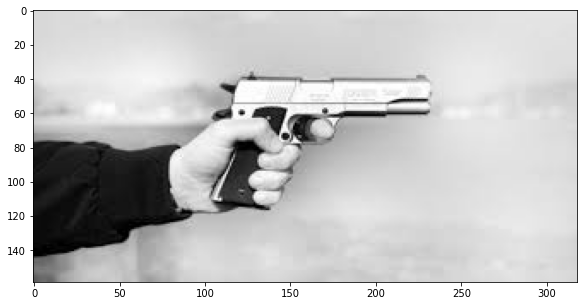

In [ ]:
im = cv2.imread('retrieval/131.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

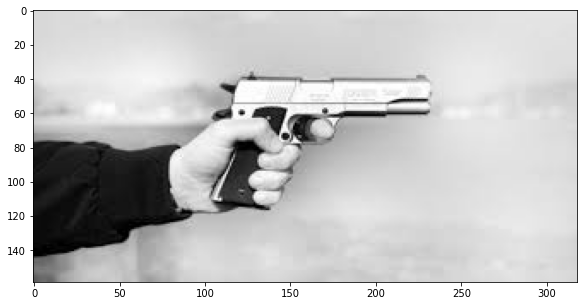

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA))

### experiment 2.1

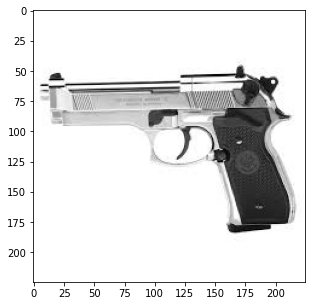

In [ ]:
template = cv2.imread('Pistol/tabanca1041.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (130,70), interpolation = cv2.INTER_AREA)

In [ ]:
template = cv2.flip(template, 1)

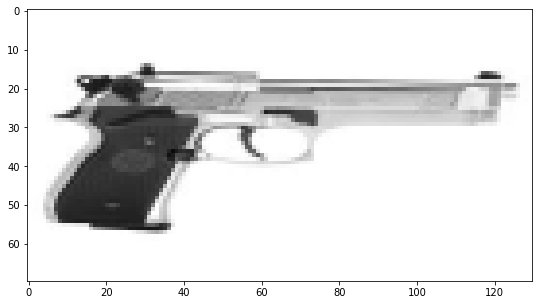

In [ ]:
plt.imshow(cr(template))

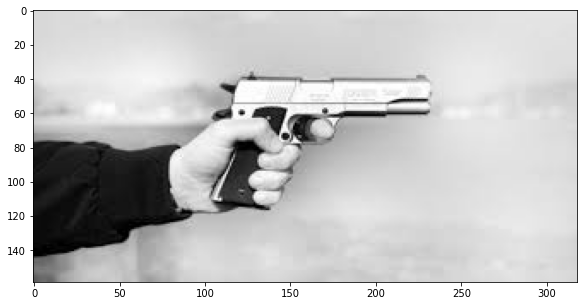

In [ ]:
im = cv2.imread('retrieval/131.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

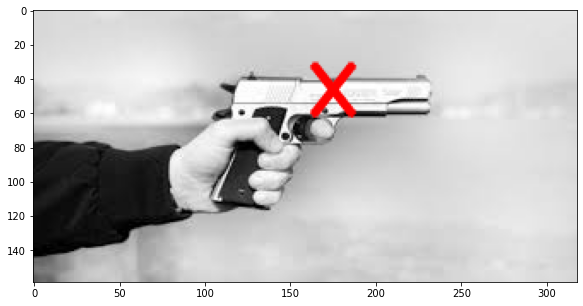

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA) )

### experiment 3

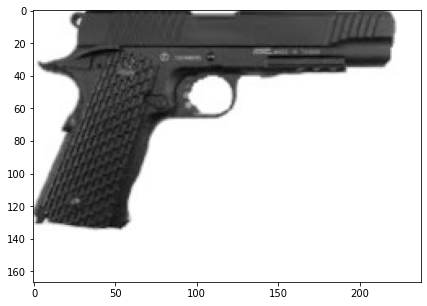

In [ ]:
template = cv2.imread('Pistol/tabanca1163.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (120,100), interpolation = cv2.INTER_AREA)

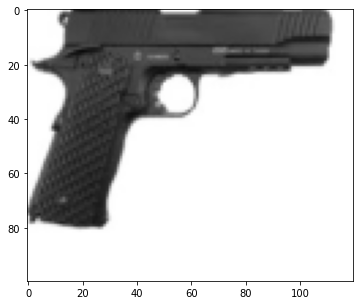

In [ ]:
plt.imshow(cr(template))

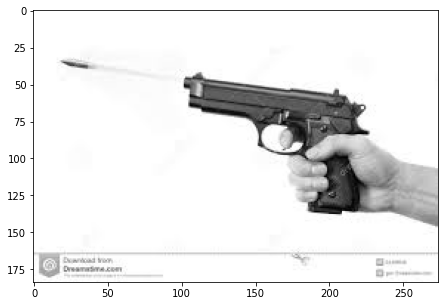

In [ ]:
im = cv2.imread('retrieval/263.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

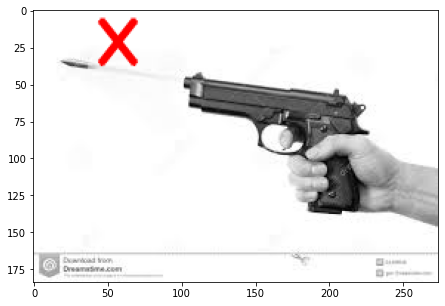

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA) )

### experiment 3.1

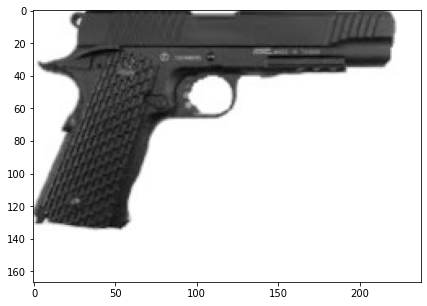

In [ ]:
template = cv2.imread('Pistol/tabanca1163.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (120,100), interpolation = cv2.INTER_AREA)

In [ ]:
template = cv2.flip(template, 1)

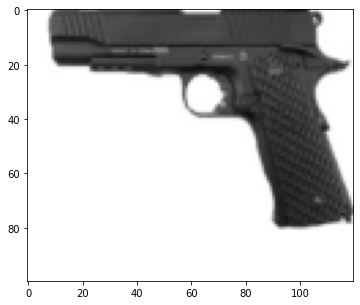

In [ ]:
plt.imshow(cr(template))

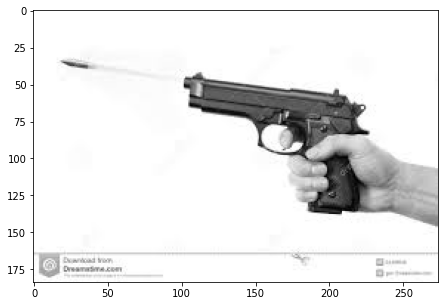

In [ ]:
im = cv2.imread('retrieval/263.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

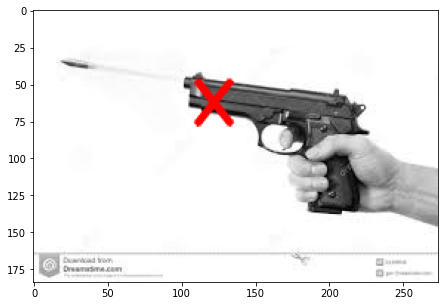

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA) )

### experiment 4

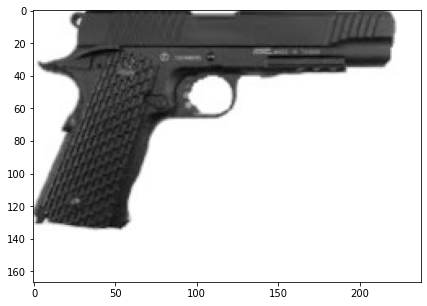

In [ ]:
template = cv2.imread('Pistol/tabanca1163.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (130,70), interpolation = cv2.INTER_AREA)

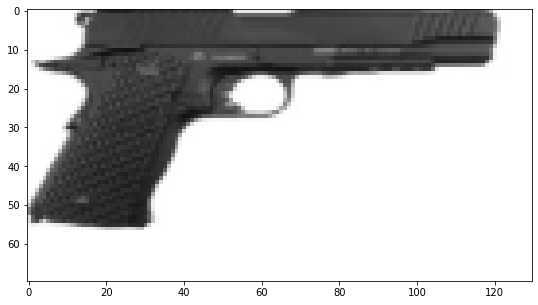

In [ ]:
plt.imshow(cr(template))

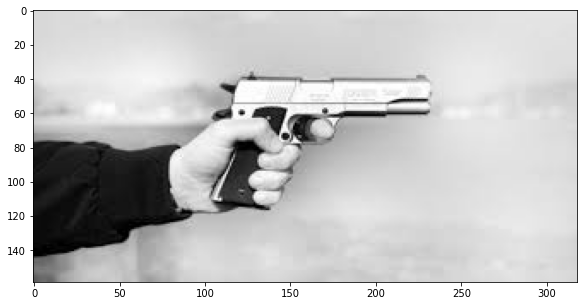

In [ ]:
im = cv2.imread('retrieval/131.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

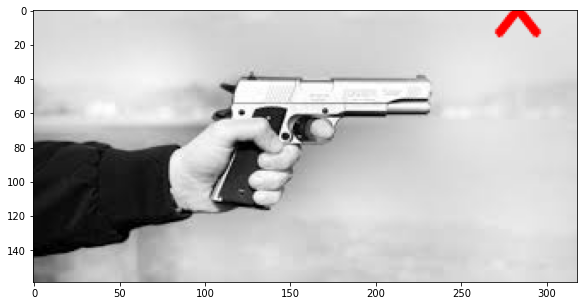

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA) )

### experiment 5

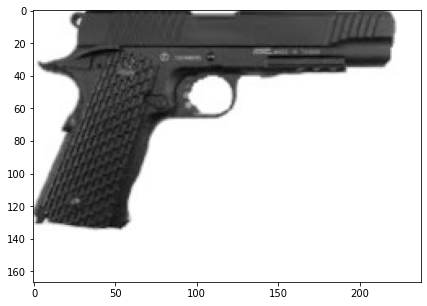

In [ ]:
template = cv2.imread('Pistol/tabanca1163.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (70,50), interpolation = cv2.INTER_AREA)

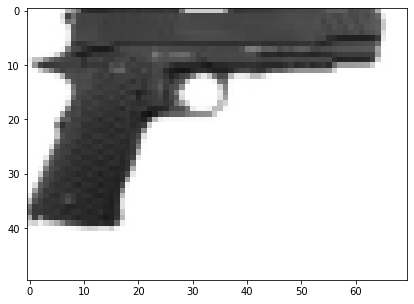

In [ ]:
plt.imshow(cr(template))

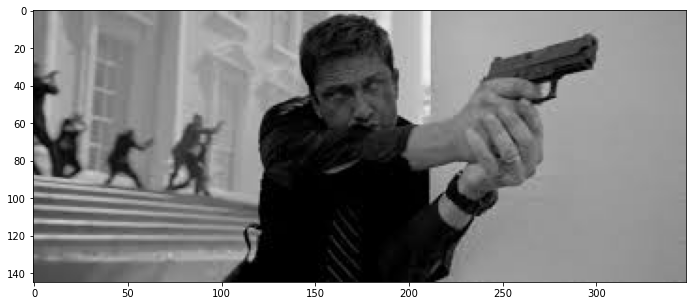

In [ ]:
im = cv2.imread('retrieval/288.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

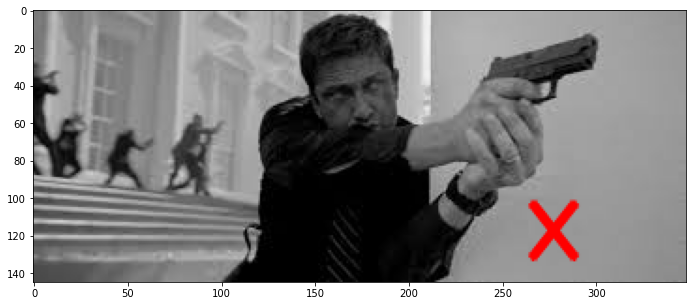

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA) )

### experiment 6

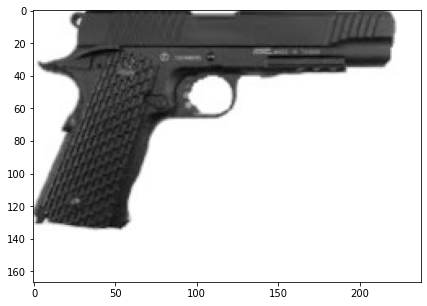

In [ ]:
template = cv2.imread('Pistol/tabanca1163.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (50,30), interpolation = cv2.INTER_AREA)

In [ ]:
template = cv2.flip(template, 1)

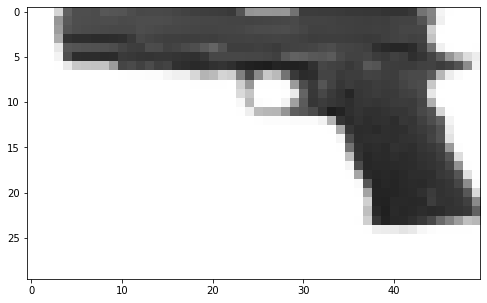

In [ ]:
plt.imshow(cr(template))

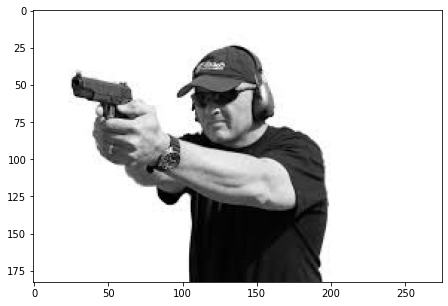

In [ ]:
im = cv2.imread('retrieval/260.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

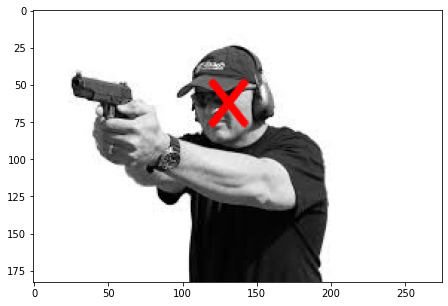

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA) )

### experiment 7



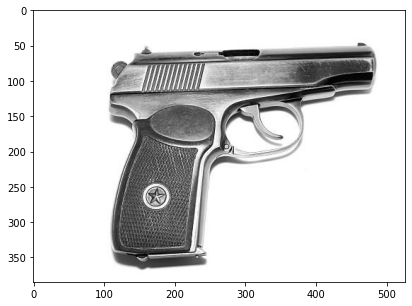

In [ ]:
template = cv2.imread('Pistol/tabanca1030.jpg',0)
plt.imshow(cr(template))
plt.show()

In [ ]:
template = cv2.resize(template, (120,70), interpolation = cv2.INTER_AREA)

In [ ]:
template = cv2.flip(template, 1)
template = cv2.rotate(template, cv2.ROTATE_90_CLOCKWISE)

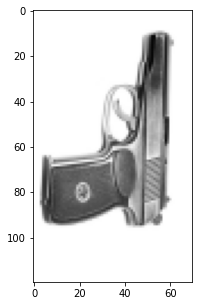

In [ ]:
plt.imshow(cr(template))

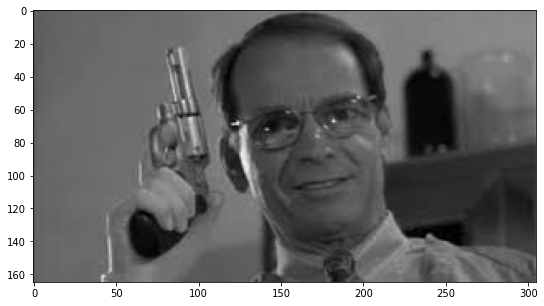

In [ ]:
im = cv2.imread('retrieval/121.jpeg',0)
plt.imshow(cr(im))
plt.show()

In [ ]:
res = normxcorr2(template, im)
res = res[slice(int(template.shape[0]/2),-int(template.shape[0]/2)+1), slice(int(template.shape[1]/2),-int(template.shape[1]/2)+1)]
y,x = np.unravel_index(res.argmax(), res.shape)

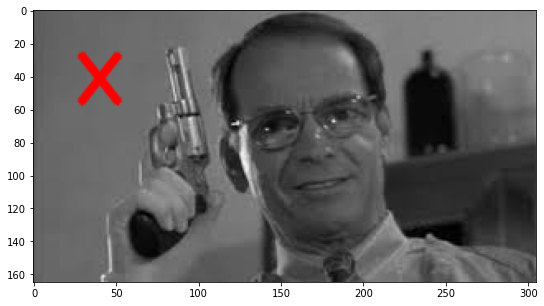

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(cr(im),'x',(x,y), font, 2,(255,0,0),3,cv2.LINE_AA) )

## CNN-BASED APPROACH

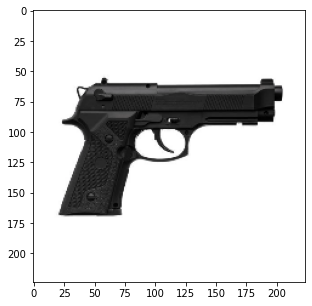

In [ ]:
pistol1 = cv2.imread('Pistol/tabanca99.jpg')
pistol1 = center_image_rgb(pistol1)
plt.imshow(pistol1)
plt.show()

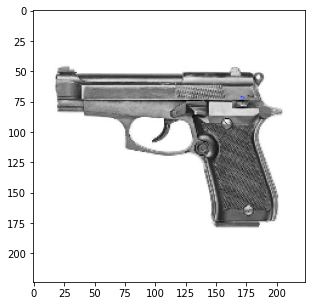

In [ ]:
pistol2 = cv2.imread('Pistol/tabanca971.jpg')
pistol2 = center_image_rgb(pistol2)
plt.imshow(pistol2)
plt.show()

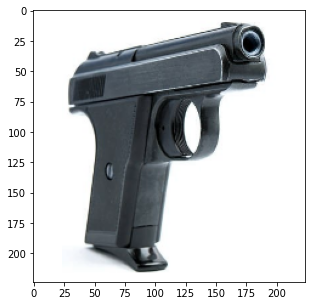

In [ ]:
pistol3 = cv2.imread('Pistol/tabanca1009.jpg')
pistol3 = center_image_rgb(pistol3)
plt.imshow(pistol3)
plt.show()

In [ ]:
pistol_1_rotation = [rotate_image(pistol1, angle) for angle in [45,90,135,180,225,270,315]]
pistol_1_rotation_flip = [rotate_image(cv2.flip(pistol1,1), angle) for angle in [45,90,135,180,225,270,315]]
template1 = np.concatenate((pistol_1_rotation, pistol_1_rotation_flip))

pistol_2_rotation = [rotate_image(pistol2, angle) for angle in [45,90,135,180,225,270,315]]
pistol_2_rotation_flip = [rotate_image(cv2.flip(pistol2,1), angle) for angle in [45,90,135,180,225,270,315]]
template2 = np.concatenate((pistol_2_rotation, pistol_2_rotation_flip))

pistol_3_rotation = [rotate_image(pistol3, angle) for angle in [45,90,135,180,225,270,315]]
pistol_3_rotation_flip = [rotate_image(cv2.flip(pistol3,1), angle) for angle in [45,90,135,180,225,270,315]]
template3 = np.concatenate((pistol_3_rotation, pistol_3_rotation_flip))

#### experiment 1

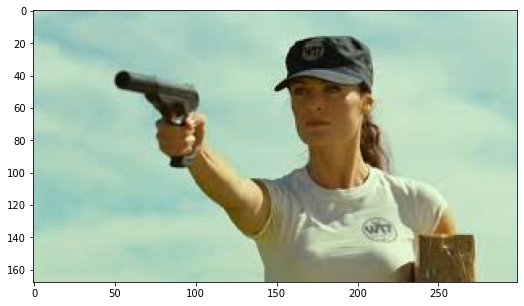

In [ ]:
img_name = '270'
img = cv2.imread(f'retrieval/{img_name}.jpeg')
plt.imshow(cr(img))
plt.show()

In [ ]:
a,b = split_image(img)
best = get_best_square(a,b, template1,template2,template3)

100%|██████████| 14/14 [01:43<00:00,  7.36s/it]


In [ ]:
prev = best[np.argmin(best[-3:])]
label = get_label(img_name)

In [ ]:
print(f"Il miglior risultato è fornito da: **{['Template1', 'Template2', 'Template3'][np.argmin(best[-3:])]}**")
print("Legenda: \n Template1: ROSSO \n Template2: VERDE \n Template3: BLU")

Il miglior risultato è fornito da: **Template1**
Legenda: 
 Template1: ROSSO 
 Template2: VERDE 
 Template3: BLU


In [ ]:
print(best)

[[80, 140, 80, 140], [80, 180, 40, 140], [100, 200, 20, 120], 0.2734874486923218, 0.26703691482543945, 0.30113136768341064]


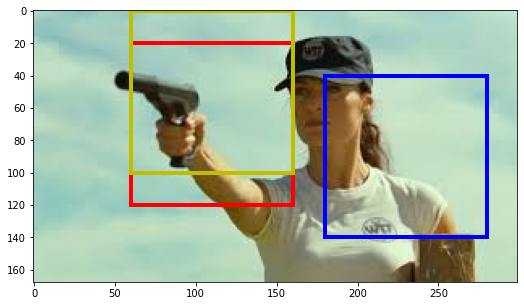

In [ ]:
fig, ax = plt.subplots()
ax.imshow(cr(img))
rect = patches.Rectangle((best[0][0], best[0][2]), best[0][1]-best[0][0], best[0][3]-best[0][2], linewidth=4, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((best[1][0], best[1][2]), best[1][1]-best[1][0], best[1][3]-best[1][2], linewidth=4, edgecolor='y', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((best[2][0], best[2][2]), best[2][1]-best[2][0], best[2][3]-best[2][2], linewidth=4, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.show()

In [ ]:
print(f'precisione del migliore: {round(get_metric(prev, label)*100 ,1)}%')
print('-------')
print(f'precisione del primo: \t{round(get_metric(best[0], label)*100 ,1)}%')
print(f'precisione del secondo: {round(get_metric(best[1], label)*100 ,1)}%')
print(f'precisione del terzo: \t{round(get_metric(best[2], label)*100 ,1)}%')

precisione del migliore: 15.6%
-------
precisione del primo: 	15.6%
precisione del secondo: 15.6%
precisione del terzo: 	0.0%


#### experiment 2

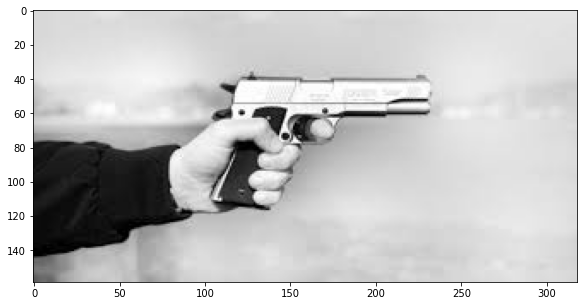

In [ ]:
img_name = '131'
img = cv2.imread(f'retrieval/{img_name}.jpeg')
plt.imshow(cr(img))
plt.show()

In [ ]:
a,b = split_image(img)
best = get_best_square(a,b, template1,template2,template3)

100%|██████████| 14/14 [01:34<00:00,  6.76s/it]


In [ ]:
prev = best[np.argmin(best[-3:])]
label = get_label(img_name)

In [ ]:
print(f"Il miglior risultato è fornito da: **{['Template1', 'Template2', 'Template3'][np.argmin(best[-3:])]}**")
print("Legenda: \n Template1: ROSSO \n Template2: VERDE \n Template3: BLU")

Il miglior risultato è fornito da: **Template2**
Legenda: 
 Template1: ROSSO 
 Template2: VERDE 
 Template3: BLU


In [ ]:
print(best)

[[80, 140, 80, 140], [80, 180, 40, 140], [100, 200, 20, 120], 0.2734874486923218, 0.26703691482543945, 0.30113136768341064]


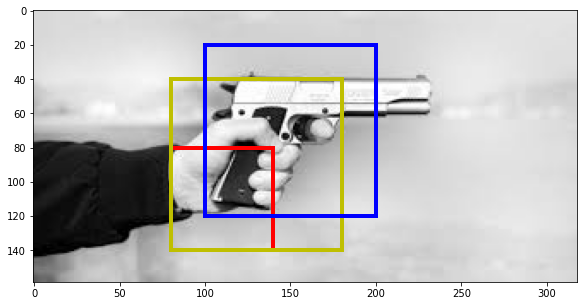

In [ ]:
fig, ax = plt.subplots()
ax.imshow(cr(img))
rect = patches.Rectangle((best[0][0], best[0][2]), best[0][1]-best[0][0], best[0][3]-best[0][2], linewidth=4, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((best[1][0], best[1][2]), best[1][1]-best[1][0], best[1][3]-best[1][2], linewidth=4, edgecolor='y', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((best[2][0], best[2][2]), best[2][1]-best[2][0], best[2][3]-best[2][2], linewidth=4, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.show()

In [ ]:
print(f'precisione del migliore: {round(get_metric(prev, label)*100 ,1)}%')
print('-------')
print(f'precisione del primo: \t{round(get_metric(best[0], label)*100 ,1)}%')
print(f'precisione del secondo: {round(get_metric(best[1], label)*100 ,1)}%')
print(f'precisione del terzo: \t{round(get_metric(best[2], label)*100 ,1)}%')

precisione del migliore: 35.1%
-------
precisione del primo: 	8.0%
precisione del secondo: 35.1%
precisione del terzo: 	54.2%


#### experiment 3

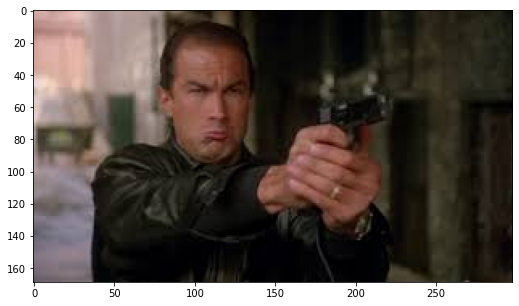

In [ ]:
img_name = '55'
img = cv2.imread(f'retrieval/{img_name}.jpeg')
plt.imshow(cr(img))
plt.show()

In [ ]:
a,b = split_image(img)
best = get_best_square(a,b, template1,template2,template3)

100%|██████████| 14/14 [01:35<00:00,  6.81s/it]


In [ ]:
prev = best[np.argmin(best[-3:])]
label = get_label(img_name)

In [ ]:
print(f"Il miglior risultato è fornito da: **{['Template1', 'Template2', 'Template3'][np.argmin(best[-3:])]}**")
print("Legenda: \n Template1: ROSSO \n Template2: VERDE \n Template3: BLU")

Il miglior risultato è fornito da: **Template2**
Legenda: 
 Template1: ROSSO 
 Template2: VERDE 
 Template3: BLU


In [ ]:
print(best)

[[180, 240, 40, 100], [160, 260, 0, 100], [0, 60, 40, 100], 0.3424740433692932, 0.3303868770599365, 0.3641207218170166]


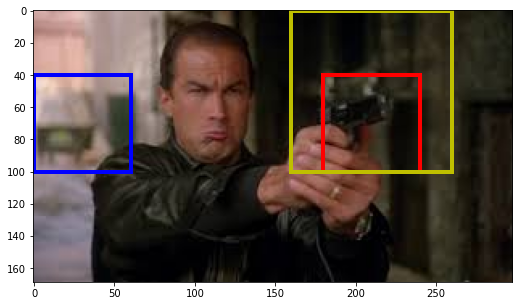

In [ ]:
fig, ax = plt.subplots()
ax.imshow(cr(img))
rect = patches.Rectangle((best[0][0], best[0][2]), best[0][1]-best[0][0], best[0][3]-best[0][2], linewidth=4, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((best[1][0], best[1][2]), best[1][1]-best[1][0], best[1][3]-best[1][2], linewidth=4, edgecolor='y', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((best[2][0], best[2][2]), best[2][1]-best[2][0], best[2][3]-best[2][2], linewidth=4, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.show()

In [ ]:
print(f'precisione del migliore: {round(get_metric(prev, label)*100 ,1)}%')
print('-------')
print(f'precisione del primo: \t{round(get_metric(best[0], label)*100 ,1)}%')
print(f'precisione del secondo: {round(get_metric(best[1], label)*100 ,1)}%')
print(f'precisione del terzo: \t{round(get_metric(best[2], label)*100 ,1)}%')

precisione del migliore: 13.0%
-------
precisione del primo: 	33.3%
precisione del secondo: 13.0%
precisione del terzo: 	0.0%


#### experiment 4

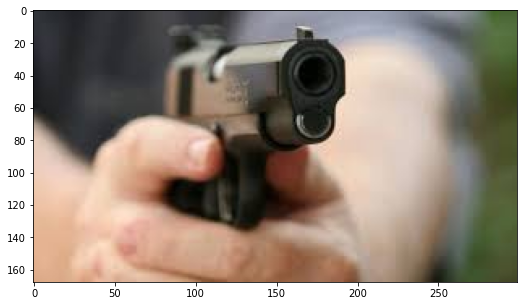

In [ ]:
img_name = '135'
img = cv2.imread(f'retrieval/{img_name}.jpeg')
plt.imshow(cr(img))
plt.show()

In [ ]:
a,b = split_image(img)
best = get_best_square(a,b, template1,template2,template3)

100%|██████████| 14/14 [01:30<00:00,  6.48s/it]


In [ ]:
prev = best[np.argmin(best[-3:])]
label = get_label(img_name)

In [ ]:
print(f"Il miglior risultato è fornito da: **{['Template1', 'Template2', 'Template3'][np.argmin(best[-3:])]}**")
print("Legenda: \n Template1: ROSSO \n Template2: VERDE \n Template3: BLU")

Il miglior risultato è fornito da: **Template1**
Legenda: 
 Template1: ROSSO 
 Template2: VERDE 
 Template3: BLU


In [ ]:
print(best)

[[160, 220, 40, 100], [120, 180, 40, 100], [120, 180, 0, 60], 0.27759039402008057, 0.28746187686920166, 0.3066471219062805]


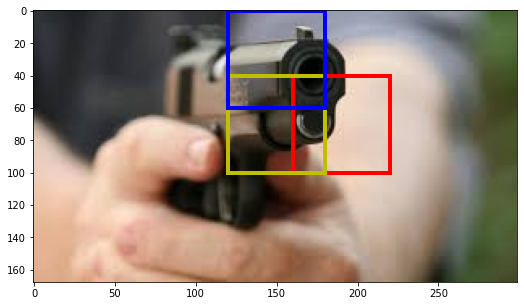

In [ ]:
fig, ax = plt.subplots()
ax.imshow(cr(img))
rect = patches.Rectangle((best[0][0], best[0][2]), best[0][1]-best[0][0], best[0][3]-best[0][2], linewidth=4, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((best[1][0], best[1][2]), best[1][1]-best[1][0], best[1][3]-best[1][2], linewidth=4, edgecolor='y', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((best[2][0], best[2][2]), best[2][1]-best[2][0], best[2][3]-best[2][2], linewidth=4, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.show()

In [ ]:
print(f'precisione del migliore: {round(get_metric(prev, label)*100 ,1)}%')
print('-------')
print(f'precisione del primo: \t{round(get_metric(best[0], label)*100 ,1)}%')
print(f'precisione del secondo: {round(get_metric(best[1], label)*100 ,1)}%')
print(f'precisione del terzo: \t{round(get_metric(best[2], label)*100 ,1)}%')

precisione del migliore: 17.6%
-------
precisione del primo: 	17.6%
precisione del secondo: 21.9%
precisione del terzo: 	18.0%


# EVALUATION ON THE DATASET

carichiamo un dataset contenente 50 immagini prese da scene reali dove è presente una pistola. Valuteremo le performance del nostro metodo sulla base di come si comporta per questi esempi di test.

In [ ]:
copytree('gdrive/MyDrive/Data_DigitalSignalsProject/retrieval_for_evaluation', 'retrieval_for_evaluation')

'retrieval_for_evaluation'

In [ ]:
best_template = []
first_template = []
second_template = []
third_template = []

for i in tqdm(os.listdir('retrieval_for_evaluation')[:50]):
  img_name = i[:-5]
  img = cv2.imread(f'retrieval_for_evaluation/{img_name}.jpeg')
  a,b = split_image(img)
  best = get_best_square(a,b, template1,template2,template3)

  prev = best[np.argmin(best[-3:])]
  label = get_label(img_name)

  best_template.append(round(get_metric(prev, label)*100 ,1))
  first_template.append(round(get_metric(best[0], label)*100 ,1))
  second_template.append(round(get_metric(best[1], label)*100 ,1))
  third_template.append(round(get_metric(best[2], label)*100 ,1))

100%|██████████| 50/50 [4:25:01<00:00, 318.02s/it]


In [ ]:
data = pd.DataFrame()
data['best'] = best_template
data['first'] = first_template 
data['second'] = second_template 
data['third'] = third_template 

In [ ]:
data

,best,first,second,third
0,44.6,44.6,44.6,0.0
1,45.7,24.0,45.7,29.5
2,0.0,0.0,5.4,0.0
3,23.9,18.4,23.9,23.9
4,36.9,12.9,36.9,17.5
5,39.0,39.0,39.0,0.0
6,43.4,0.0,43.4,0.0
7,17.5,17.5,17.5,41.3
8,0.0,0.0,0.0,0.0
9,26.7,26.7,15.8,39.2


In [ ]:
print(f"media della sovrapposizione tra la nostra previsione e il box reale: {round(np.mean(data['best']) ,1)}%")

media della sovrapposizione tra la nostra previsione e il box reale: 23.9%


In [ ]:
print(f"Percentuale delle immagini in cui la nostra previsione si sovrappone con il box reale: {len(data[data['best']!=0])/len(data)*100}%")

Percentuale delle immagini in cui la nostra previsione si sovrappone con il box reale: 84.0%


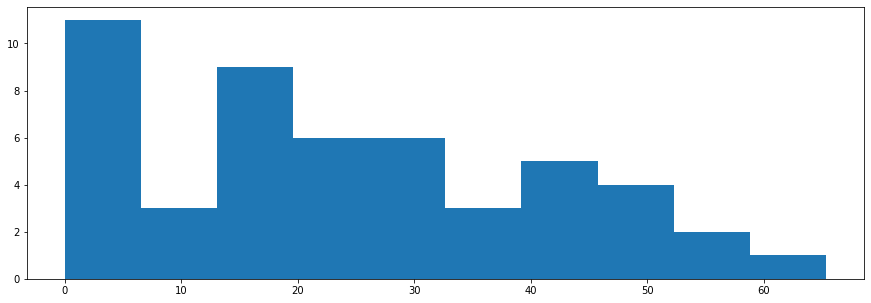

In [ ]:
plt.hist(data['best'])
plt.show()

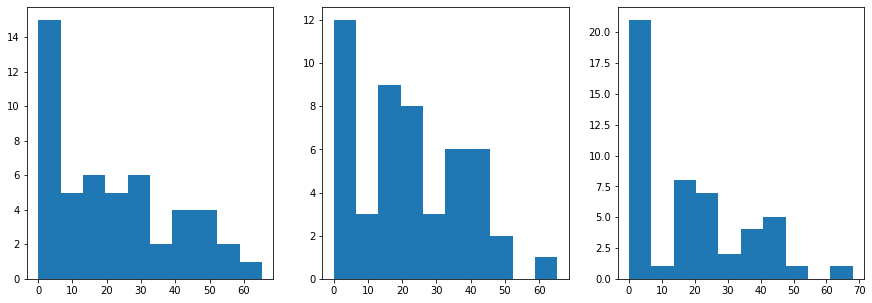

In [ ]:
plt.subplot(1,3,1)
plt.hist(data['first'])

plt.subplot(1,3,2)
plt.hist(data['second'])

plt.subplot(1,3,3)
plt.hist(data['third'])

plt.show()